In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 9})
# PyTorch
import torch

In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import models
import utils

/cluster/tufts/hugheslabkp/eharve06/miniconda3/envs/l3d_2024f_cuda12_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
delta, deltaS = 2.0, 3
X_train, lengths_train, u_train, y_train = utils.generate_toy_data(400, delta=delta, deltaS=deltaS, seed=0)
X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, deltaS=deltaS, seed=1)
X_test, lengths_test, u_test, y_test = utils.generate_toy_data(1000, delta=delta, deltaS=deltaS, seed=2)

In [4]:
def uniform_pdf(x, a, b):
    pdf = torch.zeros_like(x, dtype=torch.float)
    mask = (x >= a) & (x <= b)
    pdf[mask] = 1.0 / (b - a)
    return pdf

cpu


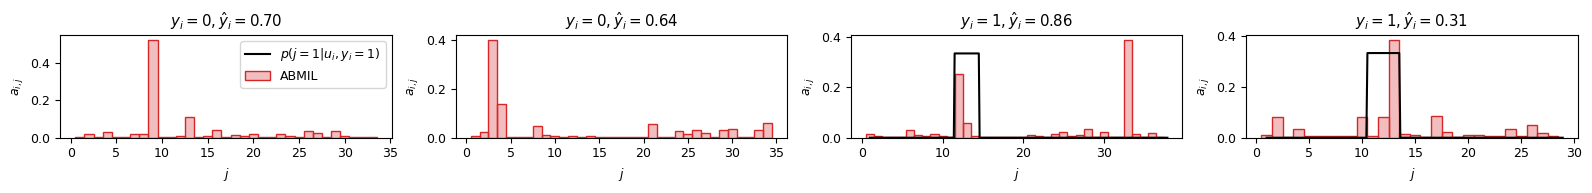

In [5]:
model = models.ClfPool(in_features=768, out_features=1, instance_conv=False, pooling="attention", use_pos_embedding=False)
checkpoint_path = "/cluster/tufts/hugheslab/eharve06/pooling/experiments/test/alpha=0.01_criterion=L1_lr=0.01_pooling=attention_seed=1001_use_pos_embedding=False.pt"
checkpoint_state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"), weights_only=False)
model.load_state_dict(checkpoint_state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

with torch.no_grad():
    logits, attn_weights = model(X_test, lengths_test)
    y_hat = torch.sigmoid(logits)

ncols, nrows = 4, 1
fig, axs = plt.subplots(figsize=(4*ncols, 2*nrows), ncols=ncols, nrows=nrows)

for index in range(4):
    
    a, b = u_test[index] + 0.5, u_test[index] + deltaS + 0.5
    js = torch.arange(1, lengths_test[index]+1)
    xs = torch.arange(1, lengths_test[index]+1, 0.1)

    if y_test[index] == 1:
        axs[index].plot(xs, uniform_pdf(xs, a, b), color="#000000", label=r"$p(j=1 | u_i, y_i=1)$")
    else:
        axs[index].plot([], [], color="#000000", label=r"$p(j=1 | u_i, y_i=1)$")
    axs[index].bar(js, torch.split(attn_weights, lengths_test)[index].view(-1), color=colors.to_rgba("#D62728", alpha=0.3), edgecolor='#D62728', label="ABMIL", width=1)
    axs[index].set_title(rf"$y_i={int(y_test[index])}, \hat{{y}}_i={float(y_hat[index]):.2f}$")
    axs[index].set_xlabel(r"$j$")
    axs[index].set_ylabel(r"$a_{i,j}$")

axs[0].legend()
    
fig.tight_layout()
fig.savefig("attention_weights1.pdf", bbox_inches="tight")
plt.show()

cpu


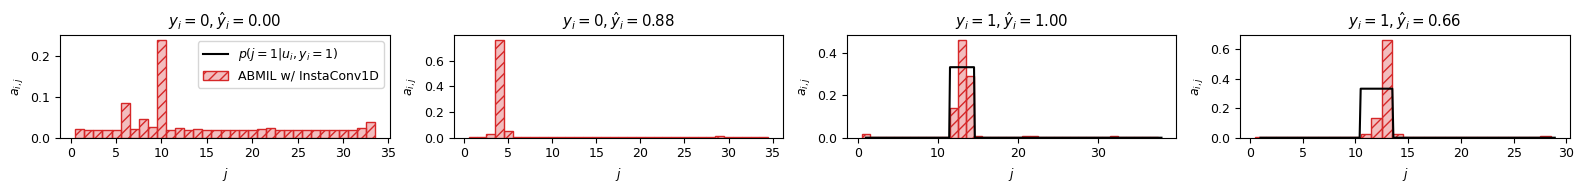

In [6]:
model = models.ClfPool(in_features=768, out_features=1, instance_conv=True, kernel_size=3, pooling="attention", use_pos_embedding=False)
checkpoint_path = "/cluster/tufts/hugheslab/eharve06/pooling/experiments/test/alpha=0.01_criterion=L1_lr=0.1_pooling=attention_seed=1001_use_pos_embedding=False.pt"
checkpoint_state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"), weights_only=False)
model.load_state_dict(checkpoint_state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

with torch.no_grad():
    logits, attn_weights = model(X_test, lengths_test)
    y_hat = torch.sigmoid(logits)

ncols, nrows = 4, 1
fig, axs = plt.subplots(figsize=(4*ncols, 2*nrows), ncols=ncols, nrows=nrows)

for index in range(4):
    
    a, b = u_test[index] + 0.5, u_test[index] + deltaS + 0.5
    js = torch.arange(1, lengths_test[index]+1)
    xs = torch.arange(1, lengths_test[index]+1, 0.1)

    if y_test[index] == 1:
        axs[index].plot(xs, uniform_pdf(xs, a, b), color="#000000", label=r"$p(j=1 | u_i, y_i=1)$")
    else:
        axs[index].plot([], [], color="#000000", label=r"$p(j=1 | u_i, y_i=1)$")
    axs[index].bar(js, torch.split(attn_weights, lengths_test)[index].view(-1), color=colors.to_rgba("#D62728", alpha=0.3), edgecolor='#D62728', hatch="///", label="ABMIL w/ InstaConv1D", width=1)
    axs[index].set_title(rf"$y_i={int(y_test[index])}, \hat{{y}}_i={float(y_hat[index]):.2f}$")
    axs[index].set_xlabel(r"$j$")
    axs[index].set_ylabel(r"$a_{i,j}$")
    
axs[0].legend()
    
fig.tight_layout()
fig.savefig("attention_weights2.pdf", bbox_inches="tight")
plt.show()

cpu
tensor([[0.0258],
        [0.0265],
        [0.0273],
        ...,
        [0.0249],
        [0.0242],
        [0.0236]])


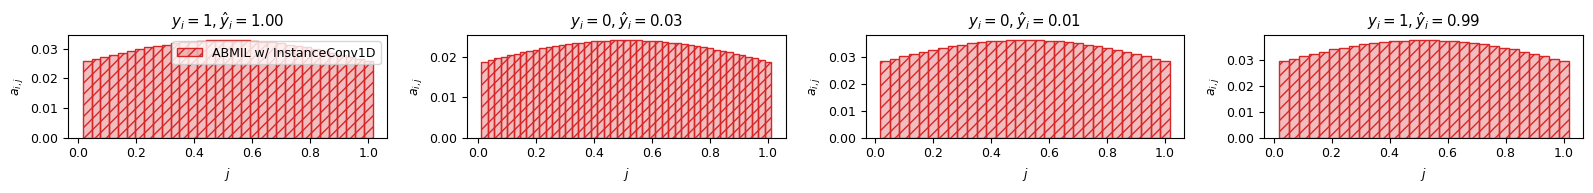

In [180]:
model = models.ClfPool(in_features=768, out_features=1, instance_conv=True, pooling="normal", use_pos_embedding=False)
checkpoint_path = "/cluster/tufts/hugheslab/eharve06/pooling/experiments/test/alpha=0.01_beta=1.0_criterion=GuidedL1_lr=0.1_pooling=normal_seed=1001_use_pos_embedding=False.pt"
checkpoint_state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"), weights_only=False)
model.load_state_dict(checkpoint_state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

with torch.no_grad():
    logits, attn_weights = model(X_train, lengths_train)
    print(attn_weights)
    #means, stds = attn_weights
    y_hat = torch.sigmoid(logits)

ncols, nrows = 4, 1
fig, axs = plt.subplots(figsize=(4*ncols, 2*nrows), ncols=ncols, nrows=nrows)

for index in range(4):
    
    a, b = (u_train[index] + 0.5) / lengths_train[index], (u_train[index] + deltaS + 0.5) / lengths_train[index]
    js = torch.arange(1, lengths_train[index]+1) / lengths_train[index]
    xs = torch.arange(1, lengths_train[index]+1, 0.1) / lengths_train[index]

    #if y_train[index] == 1:
    #    axs[index].plot(xs, uniform_pdf(xs, a, b), color="#000000", label=r"$p(j=1 | u_i, y_i=1)$")
    #else:
    #    axs[index].plot([], [], color="#000000", label=r"$p(j=1 | u_i, y_i=1)$")
    axs[index].bar(js, torch.split(attn_weights, lengths_train)[index].view(-1), color=colors.to_rgba("#D62728", alpha=0.3), edgecolor='#D62728', hatch="///", label="ABMIL w/ InstanceConv1D", width=1/lengths_train[index])
    #axs[index].bar(js, utils.normal_pdf(js, means[index], stds[index]), color=colors.to_rgba("#D62728", alpha=0.3), edgecolor='#D62728', hatch="///", label="ABMIL w/ InstanceConv1D", width=1/lengths_train[index])
    
    axs[index].set_title(rf"$y_i={int(y_train[index])}, \hat{{y}}_i={float(y_hat[index]):.2f}$")
    axs[index].set_xlabel(r"$j$")
    axs[index].set_ylabel(r"$a_{i,j}$")
    
axs[0].legend()
    
fig.tight_layout()
#fig.savefig("attention_weights2.pdf", bbox_inches="tight")
plt.show()


tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000])
tensor(5.5000)
tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000])


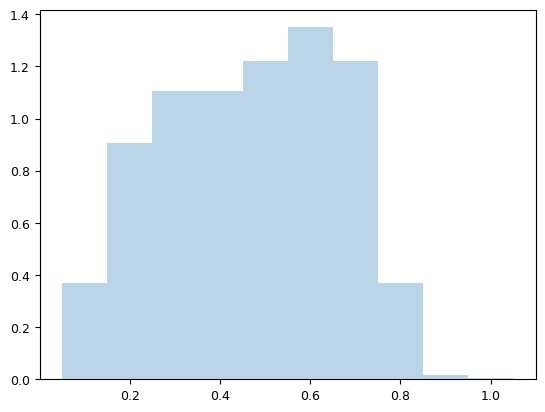

In [159]:
def get_x(y):
    return torch.arange(1, len(y) + 1, device=y.device) / len(y)

def calc_mean(y):
    assert y.dim() == 1, "calc_mean() expects 1D tensor, got shape {y.shape}"
    max_y = torch.max(y)
    w = torch.exp(y - max_y)
    x = get_x(y)
    print(x)
    return torch.sum(x * w) / torch.sum(w)

def calc_mean(y):
    x = get_x(y)
    print(x)
    return torch.sum(x * y) / torch.sum(y)
    
attn_weights = torch.tensor([0.0, 0.0, 0.1, 0.1, 0.2, 0.3, 0.2, 0.0, 0.0, 0.0])
attn_weights = torch.tensor([[-1.0], [-0.1], [0.1], [0.1], [0.2], [0.3], [0.2], [-1.0], [-4.0], [-5.0]])
#attn_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,])
plt.bar(get_x(attn_weights).view(-1), attn_weights.exp().view(-1), alpha=0.3, width=0.1)
print(calc_mean(attn_weights))
rs = utils.normal_pdf(get_x(attn_weights), calc_mean(attn_weights), 0.1)
plt.plot(get_x(attn_weights).view(-1), rs/rs.sum().view(-1))


In [ ]:
with torch.no_grad():
    logits, attn_weights = model(X_test, lengths_test)
    y_hat = torch.sigmoid(logits)

In [6]:
means, stds = attn_weights
stds.shape

torch.Size([1000])

In [12]:
criterion = losses.GuidedNormalL1Loss(alpha=1.0, beta=1.0, criterion=torch.nn.BCEWithLogitsLoss())
criterion(logits, y_test, params=torch.tensor([0.0]), lengths=lengths_test, attn_weights=attn_weights)

{'loss': tensor(335.5152), 'nll': tensor(0.7000)}